In [1]:
import numpy as np
from d3m_interface import Automl
from text_augmentation import augment_dataset
from active_learning import automatic_labeling, manual_labeling, dataframe_to_nparray

RANDOM_STATE_SEED = 0

In [2]:
output_path = '/Users/rlopez/D3M/examples/tmp/'
train_dataset_path = '/Users/rlopez/D3M/examples/JIDO_SOHR_Articles_1061/TRAIN'
test_dataset_path = '/Users/rlopez/D3M/examples/JIDO_SOHR_Articles_1061/TEST'
score_dataset_path = '/Users/rlopez/D3M/examples/JIDO_SOHR_Articles_1061/SCORE'

In [3]:
automl = Automl(output_path, 'AlphaD3M')

In [4]:
# Utils
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score
from d3m_interface.data_converter import d3mtext_to_dataframe
import pandas as pd

train_dataset = d3mtext_to_dataframe(train_dataset_path, 'article').head(5000)
test_dataset = d3mtext_to_dataframe(score_dataset_path, 'article')

def evaluate(train_dataset, test_dataset):
    pipeline = Pipeline(
                        steps = [
                                ('tfidf', TfidfVectorizer()),
                                ('classifier', GradientBoostingClassifier(random_state=RANDOM_STATE_SEED)),
                            ]
                        )
    X_train, y_train = dataframe_to_nparray(train_dataset, 'article', 'articleofinterest')
    X_test, y_test = dataframe_to_nparray(test_dataset, 'article', 'articleofinterest')
    pipeline.fit(X_train, y_train)
    predictions = pipeline.predict(X_test)
    score = f1_score(y_test, predictions)
    
    return score

def select_indices(labels, size, ratio=0.5):
    positive_size = size * ratio
    negative_size = size * (1 - ratio)
    positive_indices = []
    negative_indices = []
    selected_indices = []
    remaining_indices = []
    
    for index, label in enumerate(labels):
        if label == 1 and len(positive_indices) < positive_size:
            positive_indices.append(index)
        elif label == 0 and len(negative_indices) < negative_size:
            negative_indices.append(index)

        if len(positive_indices) == positive_size and len(negative_indices) == negative_size:
            break

    selected_indices = positive_indices + negative_indices

    for index in range(len(labels)):
        if index not in selected_indices:
            remaining_indices.append(index)
    
    return selected_indices, remaining_indices

### Saving time in Manual Annotation

In [5]:
initial_size = 100
labeled_indices, unlabeled_indices = select_indices(train_dataset['articleofinterest'].to_list(), initial_size)
initial_dataset = train_dataset.iloc[labeled_indices]
unlabeled_dataset = train_dataset.iloc[unlabeled_indices]

In [6]:
# Using initial dataset
initial_score = evaluate(initial_dataset, test_dataset)
initial_score

0.6399540977335755

### Data Augmentation

In [7]:
np.random.seed(RANDOM_STATE_SEED)
augmented_dataset = augment_dataset(initial_dataset, 'article')
augmented_score = evaluate(augmented_dataset, test_dataset)
augmented_score

Original training set size: 100
Augmented training set size: 200


0.6525375403915605

### Active Learning

Text
"Clashes in the countryside of Daraa and a female casualty in the fall of shells on Jabburin in the countryside of Homs Daraa Province, the Syrian Observatory for Human Rights: clashes took place in areas at the outskirts of al-Yadudeh town in in the countryside of Daraa, between the regime forces and militiamen loyal to them against the rebel and Islamic factions, accompanied by exchange of targeting between both parties, while exchange of fire by heavy and medium machineguns took place in Sahem al-Golan in Yarmouk Basin area in the western countryside of Daraa, between the factions against “Jaysh Khalid Ibn al-Walid” which swore allegiance to the “Islamic State” organization . Homs province, the Syrian Observatory for Human Rights: Shells landed on places in Jabburin village which is under the control of the regime forces and militiamen loyal to them in the northern countryside of Homs, which killed a woman and injured others, in addition to causing material damage."


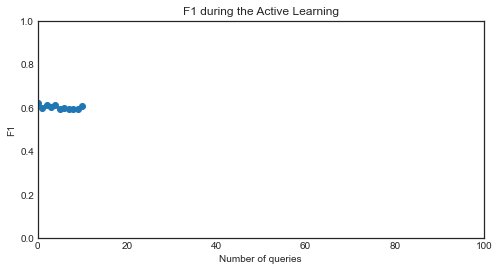

Which class is this text?
exit


In [8]:
active_learning_dataset = manual_labeling(initial_dataset, unlabeled_dataset, train_dataset)

F1 before queries: 0.6174
F1 after query 1: 0.6105
F1 after query 2: 0.6061
F1 after query 3: 0.6050
F1 after query 4: 0.6203
F1 after query 5: 0.6241
F1 after query 6: 0.6278
F1 after query 7: 0.6252
F1 after query 8: 0.6294
F1 after query 9: 0.6238
F1 after query 10: 0.6372
F1 after query 11: 0.6346
F1 after query 12: 0.6293
F1 after query 13: 0.6368
F1 after query 14: 0.6459
F1 after query 15: 0.6437
F1 after query 16: 0.6527
F1 after query 17: 0.6537
F1 after query 18: 0.6577
F1 after query 19: 0.6549
F1 after query 20: 0.6510
F1 after query 21: 0.6482
F1 after query 22: 0.6829
F1 after query 23: 0.6980
F1 after query 24: 0.6954
F1 after query 25: 0.6765
F1 after query 26: 0.6800
F1 after query 27: 0.6433
F1 after query 28: 0.6377
F1 after query 29: 0.6318
F1 after query 30: 0.6345
F1 after query 31: 0.6628
F1 after query 32: 0.5992
F1 after query 33: 0.5389
F1 after query 34: 0.5598
F1 after query 35: 0.5900
F1 after query 36: 0.6110
F1 after query 37: 0.6284
F1 after query 38: 0.

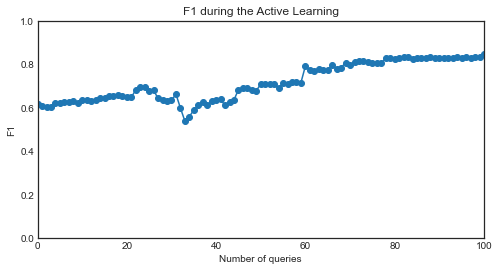

In [9]:
active_learning_dataset = automatic_labeling(initial_dataset, unlabeled_dataset, train_dataset)

In [10]:
active_learning_score = evaluate(active_learning_dataset, test_dataset)
active_learning_score

0.8820272572402045

### Combined strategy (active learning + augmentation)

In [11]:
combined_dataset = augment_dataset(active_learning_dataset, 'article')
combined_score = evaluate(combined_dataset, test_dataset)
combined_score

Original training set size: 200
Augmented training set size: 400


0.8887480190174327

### Baseline (random selection)

In [14]:
random_dataset = unlabeled_dataset.sample(n=100, random_state=RANDOM_STATE_SEED)
random_dataset = pd.concat([initial_dataset, random_dataset])
random_score = evaluate(random_dataset, test_dataset)
random_score

0.8383757961783439